# Set up

In [8]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

# Data

In [2]:
def extract_estimated_params(csv_path):
    df = pd.read_csv(csv_path)
    estimated_params_list = df["estimated_params"].apply(ast.literal_eval).tolist()
    return np.array(estimated_params_list)

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [4]:
L_GP_params = extract_estimated_params("PlotData/L.GP_21_result.csv")

L_MGP_params = extract_estimated_params("PlotData/L.MGP_21_result.csv")

L_DKMGP_params = extract_estimated_params("PlotData/L.DKMGP_21_result.csv")

MVGP_params = extract_estimated_params("PlotData/MVGP_21_result.csv")

DNN_params = extract_estimated_params("PlotData/DNN_21_result.csv")

# Plots

## Single vs. Multi

In [5]:
base_dir = "PlotData"

model_files = {
    "L_GP": "L.GP_21_result.csv",
    "L_MGP": "L.MGP_21_result.csv",
    "L_DKMGP": "L.DKMGP_21_result.csv",
    "MVGP": "MVGP_21_result.csv",
    "DNN": "DNN_21_result.csv"
}

In [6]:
mse_dict = {}
for model, filename in model_files.items():
    est = extract_estimated_params(os.path.join(base_dir, filename))

    mse_per_row = np.mean((est - X_test) ** 2, axis=1)
    mse_dict[model] = mse_per_row



mse_df = pd.DataFrame(mse_dict)


/tmp/ipykernel_1185556/2976613020.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)


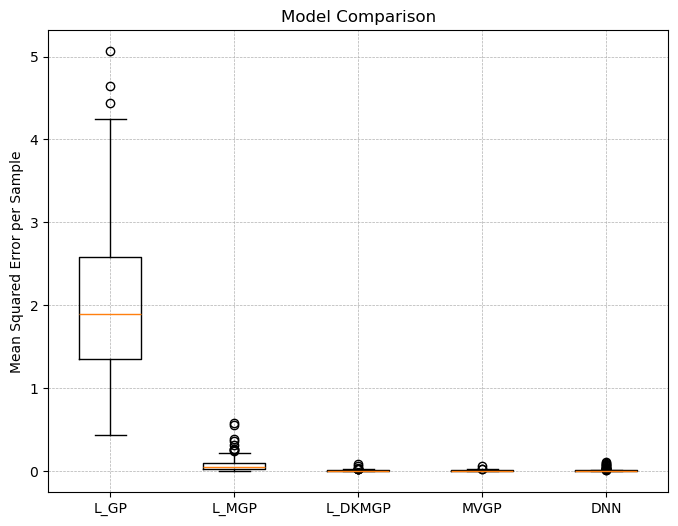

In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
plt.ylabel("Mean Squared Error per Sample")
plt.title("Model Comparison")
plt.grid(True, linestyle='--', linewidth=0.5)
# plt.ylim(0, 0.5)
plt.show()

/tmp/ipykernel_1185556/2370550041.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)


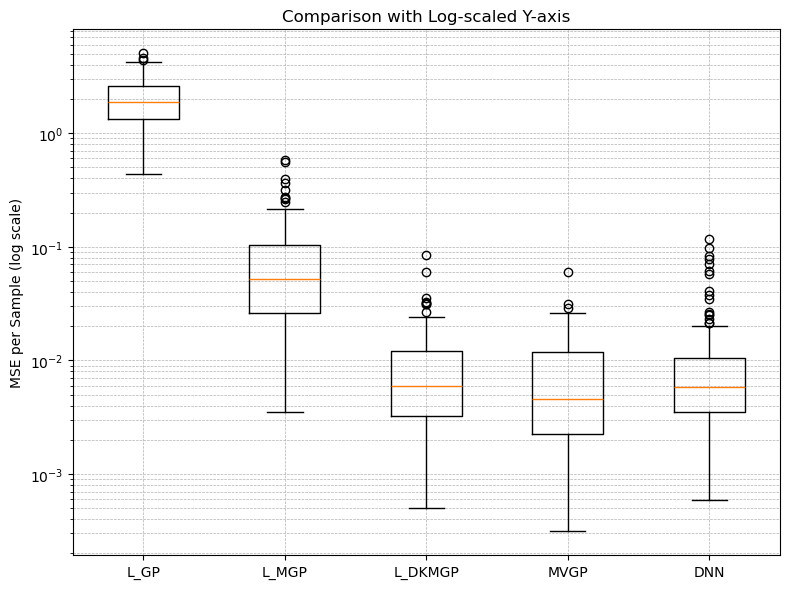

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
ax.set_yscale('log')
ax.set_ylabel("MSE per Sample (log scale)")
ax.set_title("Comparison with Log-scaled Y-axis")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()